In [1]:
!pip3 install seqeval

# New section

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
annotations = pd.read_csv("chap4_mahabharath.csv", index_col=['id'])

In [4]:
annotations

,sentence#,token,tag
id,,,
0,0,Om,CONCEPT
1,0,!,O
2,1,Having,O
3,1,bowed,O
4,1,down,O
...,...,...,...
830510,34331,The,O
830511,34331,end,O
830512,34331,of,O


In [5]:
words = list(annotations['token'].values)
words.append('PADword')
n_words = len(set(words))
n_words, len(words)

(19573, 830516)

In [6]:
tags = list(set(annotations["tag"].values))
n_tags = len(tags)
print(n_tags)
tags

12


['CONCEPT',
 'SPECIAL_OBJECT',
 'BOOK',
 'GROUP',
 'PERSON',
 'O',
 'WATER',
 'PLACE',
 'TITLE',
 'WEAPON',
 'PLANT',
 'ANIMAL']

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(annotations)
sent = getter.get_next()
print(sent)

[('Om', 'CONCEPT'), ('!', 'O')]


In [9]:
sentences = getter.sentences
print(len(sentences))

34332


In [10]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 428 words


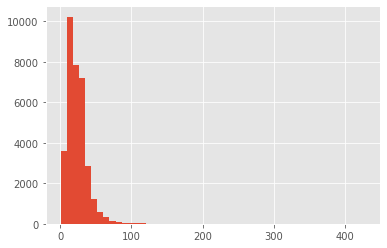

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [12]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
Y = [[w[1] for w in s] for s in sentences]
new_X = []
y_label = []
for k in range(len(X)):
    seq = X[k]
    j = 0
    while(j<len(seq)):
        new_seq = []
        new_y = []
        for i in range(j,j+max_len):
            try:
                new_seq.append(seq[i])
                new_y.append(Y[k][i])
            except:
                new_seq.append("PADword")
                new_y.append('O')
        new_X.append(new_seq)
        y_label.append(new_y)
        j=i+1

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

living_entity_tags = ['ANIMAL','PERSON','GROUP','TITLE']
non_living_entity_tags = ['BOOK','PLACE','WEAPON','SPECIAL_OBJECT','PLANT','CONCEPT','WATER']

#for extraction of entities
tags2index = {}
for tag in tags:
    if tag not in living_entity_tags and tag not in non_living_entity_tags:
        tags2index[tag] = 0
    elif tag in living_entity_tags:
        tags2index[tag] = 1
    else:
        tags2index[tag] = 2
        
# tags2index = {t:i for i,t in enumerate(tags)}
y=[]        
for labels in y_label:
    word_tag = []
    for label in labels:
#         print(label)
        word_tag.append(tags2index[label])
    y.append(np.array(word_tag))
tags2index

{'CONCEPT': 2,
 'SPECIAL_OBJECT': 2,
 'BOOK': 2,
 'GROUP': 1,
 'PERSON': 1,
 'O': 0,
 'WATER': 2,
 'PLACE': 2,
 'TITLE': 1,
 'WEAPON': 2,
 'PLANT': 2,
 'ANIMAL': 1}

In [14]:
y = np.array(y)

In [15]:
y[0], new_X[0]

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 ['Om',
  '!',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword'])

In [16]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [17]:
len(new_X)

36078

In [18]:
import keras
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda,concatenate
import seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [19]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)
batch_size = 32

In [20]:
from transformers import BertTokenizer
bert = 'farhanjafri/my-model'

# Defining BERT tokonizer
tokenizer = BertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=max_len, padding=True)

In [21]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for i in range(len(sentences)):
        inputs = tokenizer.encode_plus(sentences[i], add_special_tokens=True, max_length=max_len, padding=True, 
                                             return_attention_mask=True, return_token_type_ids=True,truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


In [22]:
len(X_tr), len(X_te), batch_size,len(X_tr)/batch_size, len(X_te)/batch_size 

(32470, 3608, 32, 1014.6875, 112.75)

In [23]:
X_tr, X_val = X_tr[:914*batch_size], X_tr[-100*batch_size:]
y_tr, y_val = y_tr[:914*batch_size], y_tr[-100*batch_size:]
#y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
#y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [24]:
X_tr_in,X_tr_mask,_ = np.array(tokenize(X_tr,tokenizer))
X_val_in,X_val_mask,_ = np.array(tokenize(X_val,tokenizer))
X_te_in,X_te_mask,_ = np.array(tokenize(X_te,tokenizer))
#y_tr_in,y_tr_mask,_ = np.array(tokenize(y_tr,tokenizer))
#y_val_in,y_val_mask,_ = np.array(tokenize(y_val,tokenizer))

In [28]:
from transformers import TFBertForPreTraining, BertConfig

In [30]:
config = BertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFBertForPreTraining.from_pretrained(bert)

input_ids_in=tf.keras.layers.Input(shape=(max_len,),name='input_token',dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_len,),name='masked_token',dtype='int32')
#input_segments_in = tf.keras.layers.Input(shape=(max_len,),name='segment_token',dtype='int32')

embedding_layer = transformer_model([input_ids_in,input_masks_in])[0]
#cls_token = embedding_layer[:,0,:]
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding_layer)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2) )(x)
x = add([x, x_rnn])  
# out = TimeDistributed(Dense(12, activation="softmax"))(x)
out = TimeDistributed(Dense(3, activation="softmax"))(x)
model = Model([input_ids_in,input_masks_in], out)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

All model checkpoint layers were used when initializing TFBertForPreTraining.

All the layers of TFBertForPreTraining were initialized from the model checkpoint at farhanjafri/my-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForPreTraining for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_pre_training_1 (TFB TFBertForPreTraining 110106428   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 1024)     127119360   tf_bert_for_pre_training_1[

In [31]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [32]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [33]:
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_accuray', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesKeras()]

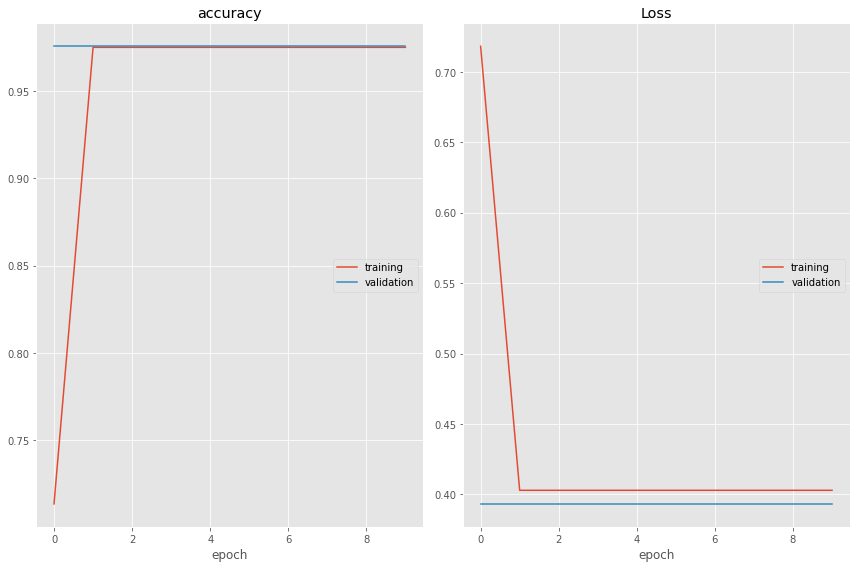

accuracy
	training         	 (min:    0.714, max:    0.975, cur:    0.975)
	validation       	 (min:    0.976, max:    0.976, cur:    0.976)
Loss
	training         	 (min:    0.403, max:    0.718, cur:    0.403)
	validation       	 (min:    0.393, max:    0.393, cur:    0.393)


In [34]:
history = model.fit([X_tr_in[:100],X_tr_mask[:100]],y_tr[:100],
                    validation_data=([X_val_in[:100],X_val_mask[:100]],y_val[:100]),
                    batch_size=batch_size, 
                    epochs=10,
                    callbacks=[callbacks], 
                    verbose=1)

In [35]:
X_te = X_te[:112*batch_size]
y_te = y_te[:112*batch_size]
X_te_in,X_te_mask,_ = np.array(tokenize(X_te,tokenizer))


In [36]:
preds = model.predict([X_te_in,X_te_mask], verbose=1, batch_size=batch_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
112/112 [==============================] - 513s 5s/step


In [37]:
# in case of classification
# idx2tag = {i: w for w, i in tags2index.items()}

# in case of extraction of entities
idx2tag = {}
for k,v in tags2index.items():
    if v == 0:
        idx2tag[v] = 'O'
    elif v == 1:
        idx2tag[v] = "LIVING"
    else:
        idx2tag[v] = "NON-LIVING"
        
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [38]:
pred_labels = pred2label(preds)

In [39]:
test_labels = test2label(y_te)

In [40]:
print(classification_report(pred_labels, test_labels))

/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NON-LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this beh

              precision    recall  f1-score   support

       IVING       0.00      0.00      0.00         0
      LIVING       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



In [41]:
print(f1_score(pred_labels, test_labels,average='micro'))

0.0
